# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - model without augmentation, with dense & dropout layer

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [11]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_1 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_additional_dense_no_augmentation'
)

model_1.summary()

Model: "mobilenet_with_additional_dense_no_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total params: 2,668,225
Trainable params: 410,241
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 100
patience = 5

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 183s 3s/step - loss: 0.5438 - binary_accuracy: 0.7948 - val_loss: 0.2619 - val_binary_accuracy: 0.8880
Epoch 2/100
58/58 [==============================] - 171s 3s/step - loss: 0.2601 - binary_accuracy: 0.8927 - val_loss: 0.2162 - val_binary_accuracy: 0.9076
Epoch 3/100
58/58 [==============================] - 169s 3s/step - loss: 0.2143 - binary_accuracy: 0.9082 - val_loss: 0.2629 - val_binary_accuracy: 0.9109
Epoch 4/100
58/58 [==============================] - 159s 3s/step - loss: 0.1834 - binary_accuracy: 0.9277 - val_loss: 0.2038 - val_binary_accuracy: 0.9109
Epoch 5/100
58/58 [==============================] - 160s 3s/step - loss: 0.1786 - binary_accuracy: 0.9310 - val_loss: 0.2270 - val_binary_accuracy: 0.9109
Epoch 6/100
58/58 [==============================] - 159s 3s/step - loss: 0.1838 - binary_accuracy: 0.9239 - val_loss: 0.2279 - val_binary_accuracy: 0.8924
Epoch 7/100
58/58 [==============================] - 159s 3s/ste

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

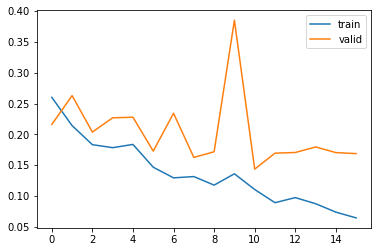

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

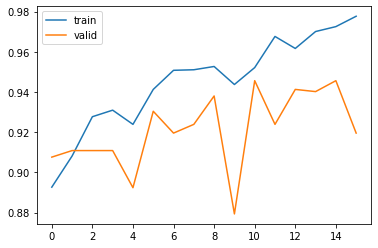

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.9375

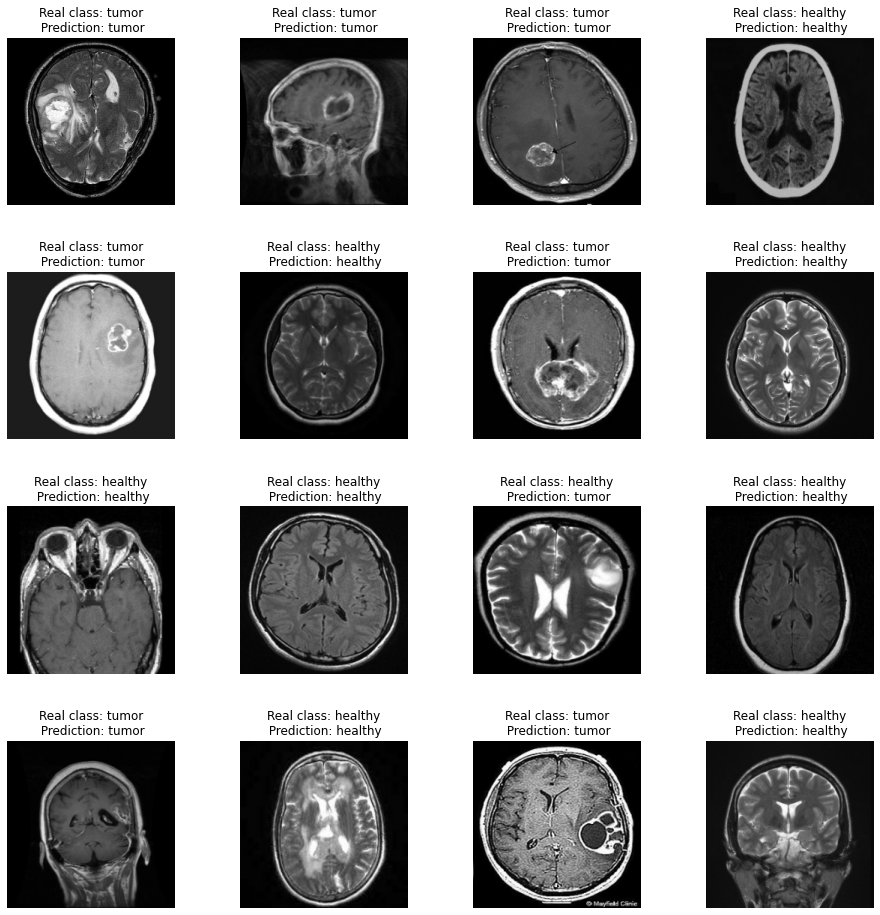

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

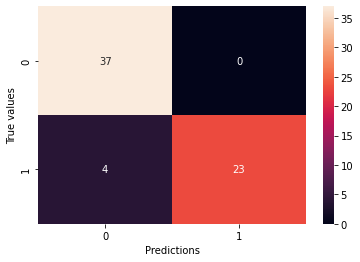

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.90      1.00      0.95        37
     Healthy       1.00      0.85      0.92        27

    accuracy                           0.94        64
   macro avg       0.95      0.93      0.93        64
weighted avg       0.94      0.94      0.94        64



## Inception_v3 - model without augmentation, with dense & dropout layer

In [23]:
input_shape = (256, 256, 3)

In [24]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_2 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='inception_with_additional_dense_no_augmentation'
)

model_2.summary()

Model: "inception_with_additional_dense_no_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               655680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 321       
Total params: 22,458,785
Trainable params: 656,001
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 100
patience = 5

In [27]:
history_2 = model_2.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 421s 7s/step - loss: 10.8403 - binary_accuracy: 0.6364 - val_loss: 4.7094 - val_binary_accuracy: 0.7239
Epoch 2/100
58/58 [==============================] - 407s 7s/step - loss: 3.7925 - binary_accuracy: 0.7321 - val_loss: 4.4395 - val_binary_accuracy: 0.6511
Epoch 3/100
58/58 [==============================] - 414s 7s/step - loss: 2.5030 - binary_accuracy: 0.7622 - val_loss: 2.6430 - val_binary_accuracy: 0.7880
Epoch 4/100
58/58 [==============================] - 419s 7s/step - loss: 2.1052 - binary_accuracy: 0.7878 - val_loss: 3.1466 - val_binary_accuracy: 0.7250
Epoch 5/100
58/58 [==============================] - 422s 7s/step - loss: 2.2718 - binary_accuracy: 0.7823 - val_loss: 1.4270 - val_binary_accuracy: 0.8261
Epoch 6/100
58/58 [==============================] - 414s 7s/step - loss: 1.3559 - binary_accuracy: 0.8307 - val_loss: 0.7181 - val_binary_accuracy: 0.8826
Epoch 7/100
58/58 [==============================] - 419s 7s/st

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

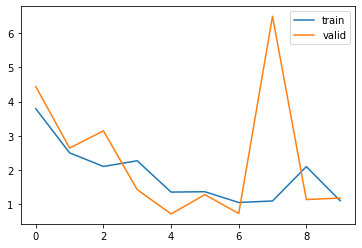

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

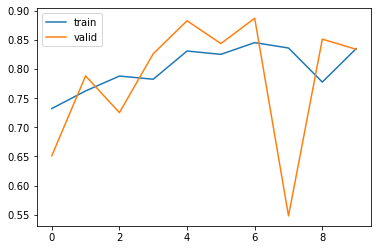

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.78125

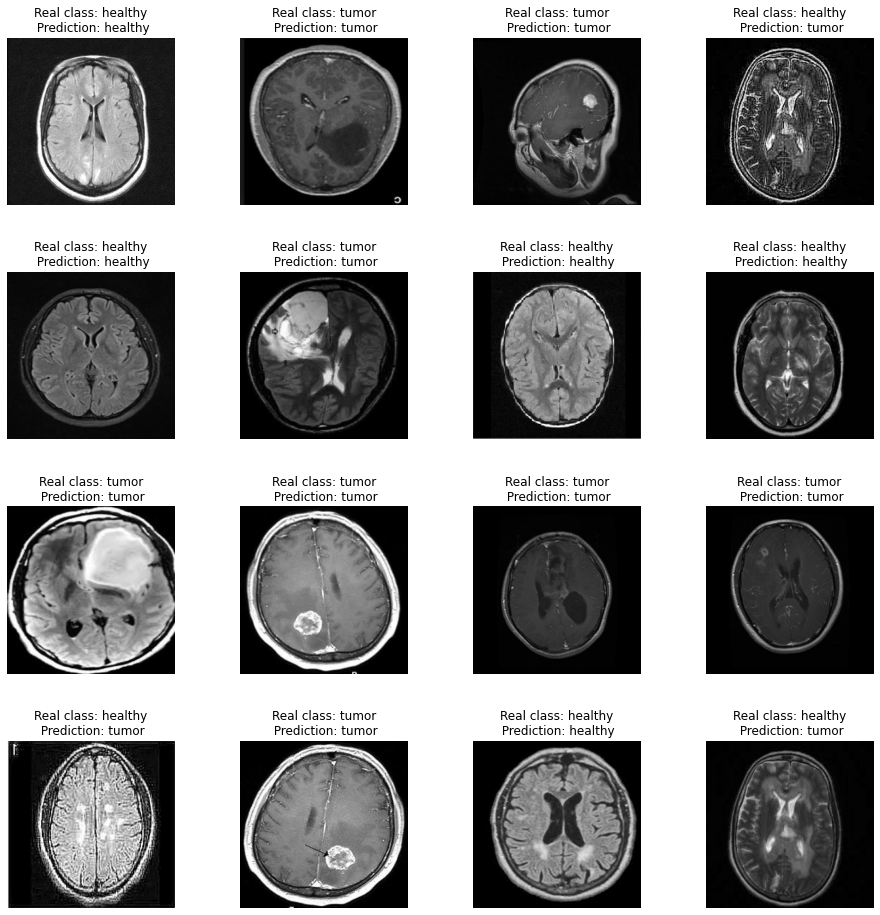

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

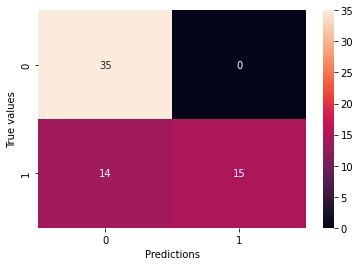

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.71      1.00      0.83        35
     Healthy       1.00      0.52      0.68        29

    accuracy                           0.78        64
   macro avg       0.86      0.76      0.76        64
weighted avg       0.84      0.78      0.76        64



## Mobilenet_v2 - dropout increase

In [36]:
input_shape = (224, 224, 3)

In [37]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [38]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [39]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_3 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.4, seed=404),
        keras.layers.Dense(1)
    ],
    name='mobilenet_dropout_increase'
)

model_3.summary()

Model: "mobilenet_dropout_increase"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 320)               409920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 321       
Total params: 2,668,225
Trainable params: 410,241
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [41]:
epochs = 100
patience = 5

In [42]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 170s 3s/step - loss: 0.5320 - binary_accuracy: 0.8014 - val_loss: 0.4588 - val_binary_accuracy: 0.7783
Epoch 2/100
58/58 [==============================] - 159s 3s/step - loss: 0.3125 - binary_accuracy: 0.8745 - val_loss: 0.2475 - val_binary_accuracy: 0.8946
Epoch 3/100
58/58 [==============================] - 161s 3s/step - loss: 0.2662 - binary_accuracy: 0.8908 - val_loss: 0.2241 - val_binary_accuracy: 0.8978
Epoch 4/100
58/58 [==============================] - 159s 3s/step - loss: 0.2125 - binary_accuracy: 0.9114 - val_loss: 0.2002 - val_binary_accuracy: 0.9087
Epoch 5/100
58/58 [==============================] - 162s 3s/step - loss: 0.1877 - binary_accuracy: 0.9255 - val_loss: 0.2414 - val_binary_accuracy: 0.9109
Epoch 6/100
58/58 [==============================] - 162s 3s/step - loss: 0.1670 - binary_accuracy: 0.9312 - val_loss: 0.2058 - val_binary_accuracy: 0.9098
Epoch 7/100
58/58 [==============================] - 160s 3s/ste

In [43]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

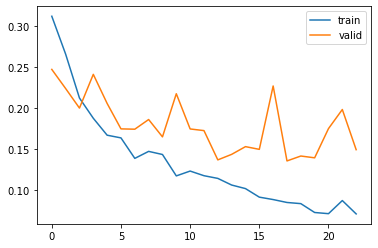

In [44]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

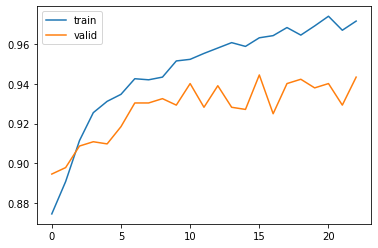

In [45]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [46]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.953125

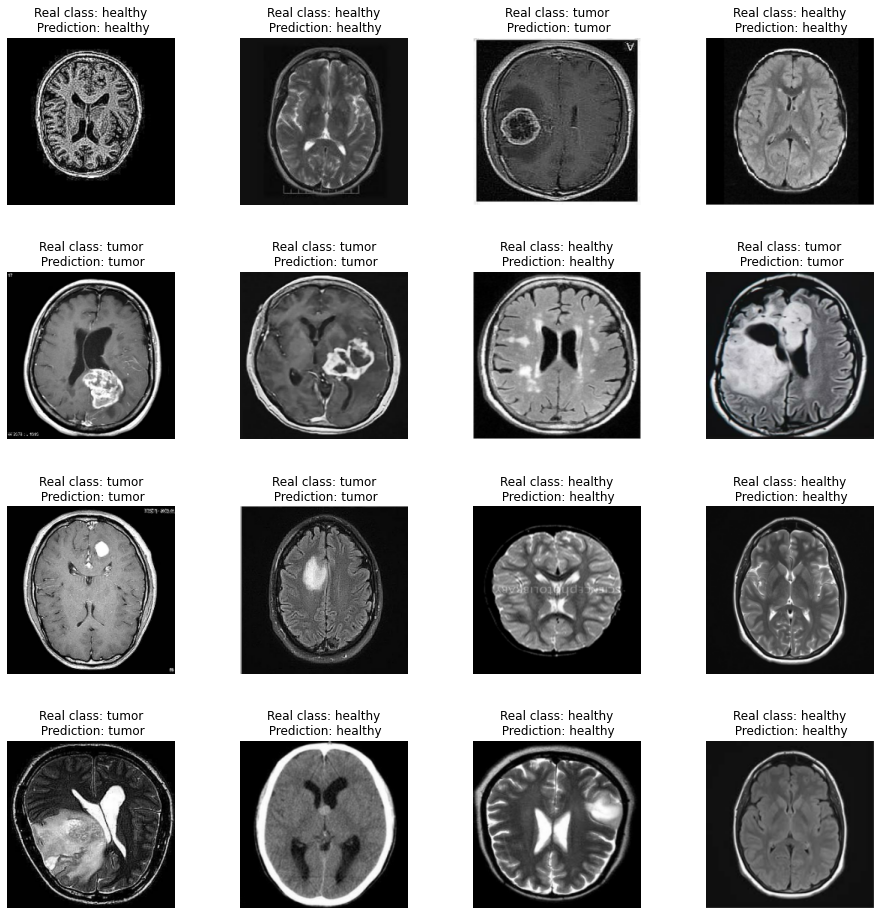

In [47]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [48]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

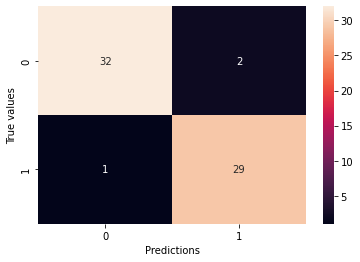

In [49]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [50]:
print(classification_report(y_val_3, y_pred_3_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.97      0.94      0.96        34
     Healthy       0.94      0.97      0.95        30

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64



## Inception_v3 - dropout increase

In [51]:
input_shape = (256, 256, 3)

In [52]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_4 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.4, seed=404),
        keras.layers.Dense(1)
    ],
    name='inception_dropout_increase'
)

model_4.summary()

Model: "inception_dropout_increase"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 320)               655680    
_________________________________________________________________
dropout_3 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 321       
Total params: 22,458,785
Trainable params: 656,001
Non-trainable params: 21,802,784
_________________________________________________________________


In [53]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [54]:
epochs = 100
patience = 5

In [55]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
58/58 [==============================] - 453s 8s/step - loss: 13.4258 - binary_accuracy: 0.6182 - val_loss: 4.4430 - val_binary_accuracy: 0.6804
Epoch 2/100
58/58 [==============================] - 440s 8s/step - loss: 3.9542 - binary_accuracy: 0.7402 - val_loss: 1.7916 - val_binary_accuracy: 0.7957
Epoch 3/100
58/58 [==============================] - 445s 8s/step - loss: 2.9301 - binary_accuracy: 0.7592 - val_loss: 1.0376 - val_binary_accuracy: 0.8739
Epoch 4/100
58/58 [==============================] - 437s 8s/step - loss: 2.8057 - binary_accuracy: 0.7764 - val_loss: 1.4706 - val_binary_accuracy: 0.8228
Epoch 5/100
58/58 [==============================] - 437s 8s/step - loss: 2.2031 - binary_accuracy: 0.7932 - val_loss: 0.9567 - val_binary_accuracy: 0.8707
Epoch 6/100
58/58 [==============================] - 423s 7s/step - loss: 2.2123 - binary_accuracy: 0.7889 - val_loss: 0.8645 - val_binary_accuracy: 0.8880
Epoch 7/100
58/58 [==============================] - 422s 7s/st

In [56]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

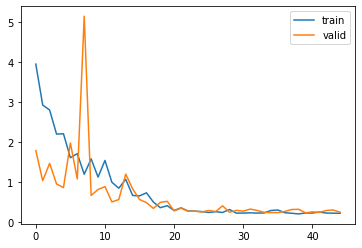

In [57]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

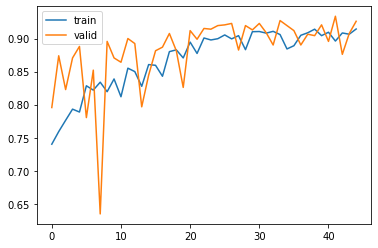

In [58]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [59]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.921875

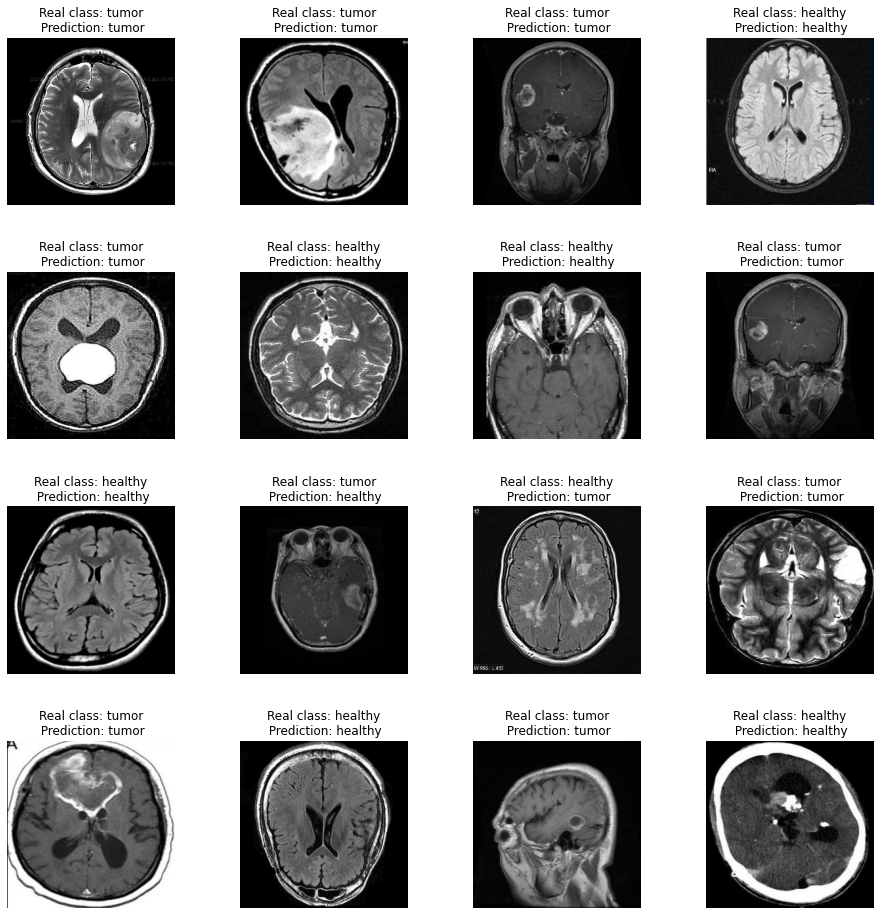

In [60]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [61]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

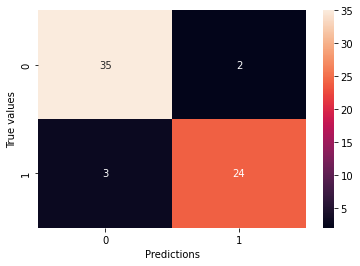

In [62]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [63]:
print(classification_report(y_val_4, y_pred_4_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.92      0.95      0.93        37
     Healthy       0.92      0.89      0.91        27

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.92        64
weighted avg       0.92      0.92      0.92        64

